# Data Mining Process

En este notebook realizaremos todo el Data Mining Process. En el apartado 2. se pueden ver los pasos a realizar:


1. Entender el problema (Problem Understanding)
2. Data Mining Process
    * Obtener los datos (Data collect)
    * Procesando los datos (Data Processing)
    * Exploración estadística de datos (Statistical Data Exploration)
    * Modelado del análisis (Analysis Modeling)
3. Resultados (Results)



Antes de nada, importamos las librerias y funciones necesarias:

In [1]:
import tensorflow as tf
import pandas as pd
import skmob
from skmob.measures.individual import home_location
from skmob.io.file import load_geolife_trajectories


## 2.1. Obtener los datos

Antes de crear el modelo usando Tensorflow, es necesario cargar la información y preprocesarla para tenerla lista para entrenar el modelo de red neuronal que usaremos.

Para cargar los datos, usamos la función 'load_geolife_trajectories' que nos proporciona skmob. Esta función se encarga de cargar los datos de GeoLife Trajectories, solo hay que indicarle el path del directorio Data, y los usuarios que queremos cargar. Es opcional pasarle algunos parámetros de filtrado y compresión.

Esta función, por cómo esta implementada, solo contempla la sintaxis de las rutas de archivos en Linux, por lo que en windows no funcionará.

In [2]:
path = "/home/alonso/Documentos/tfg/Geolife_Trajectories/"
# Cargamos los datos de los usuarios 113
traj_df = load_geolife_trajectories(path, user_ids=[120,121,122,123],
                                    compress_kwargs={'spatial_radius_km': 0.0})

## 2.2. Procesando los datos

En esta segunda fase, es importante tener una "visión global" de los datos, con el fin de entenderlos mejor. Una buena idea es ver si hay datos nulos en la información que tenemos, ya que estos deberían ser tratados. Se puede ver que en esta ocasión, no los hay. Si los hubiese, una opción podría ser la de descartar estos datos. Para realizar esto último, se podría hacer uso del método dropna() para descartar las filas con algún dato nulo los datos. Otra opcion sería remplazar los nulos por algun otro valor con fillna()

In [22]:
df = pd.DataFrame(traj_df)
print('Total de valores nulos de cada columna: ')
print(df.isna().sum() )
print('\nVistazo de los datos:')
df.head()


Total de valores nulos de cada columna: 
lat         0
lng         0
datetime    0
uid         0
at_home     0
dtype: int64

Vistazo de los datos:


,lat,lng,datetime,uid,at_home
0,39.982375,116.320442,2009-09-19 07:11:37,120,0
1,39.982380,116.320448,2009-09-19 07:11:48,120,0
2,39.982380,116.320455,2009-09-19 07:11:50,120,0
3,39.982397,116.320455,2009-09-19 07:11:52,120,0
4,39.982425,116.320460,2009-09-19 07:11:54,120,0


Para obtener la localización de las casas de cada individuo en el dataset, scikit-mobility nos proporciona la función home_location(). Esta función observa la localización más frecuentada en la noche (Entre las 22:00 y las 07:00) por los usuarios y designa a este como su casa. Estas horas son modificables, aunque no lo haremos ya que lo normal, es estar en casa entre esas horas.

In [23]:
home_loc_df = home_location(df)
home_loc_df.head()

100%|██████████| 4/4 [00:00<00:00, 125.23it/s]


,uid,lat,lng
0,120,42.405338,117.249225
1,121,39.906183,116.379599
2,122,39.968092,116.399647
3,123,34.264762,108.939026


Como ya tenemos los dos dataframes, uno con los datos GPS y otro con las localizaciones de las casas de cada individuo, es necesario trabajar con ellos para obtener los datos que buscamos.

Añadimos al dataframe de los datos GPS (nuestro 'df') una columna extra que indicará si esta en casa y la inicializamos con 0. Al dataframe con la localizacion de las casas de los individuos (home_loc_df) le añadimos una columna extra de mismo nombre, con valor 1, ya que en esa posición se encuentra la casa.

Despues, hacemos lo que en base de datos se conoce como un JOIN LEFT usando como key los valores 'lat', 'lng' y 'uid'. Con conseguiremos tener la una columna at_home_y, con el valor de 1 cuando se encuentre una coincidencia y un valor nulo cuando no y otra at_home_x con todos sus valores 0. 

Por último ya solo quedaría crear y asignar a una nueva columna at_home el valor de la columna at_home_y y rellenar los valores nulos con los de la columna at_home_x (que tienen valor 0). Despues ya solo quedaría descartar las columnas que sobran y quedarmos con at_home

In [24]:
df['at_home'] = 0
home_loc_df['at_home'] = 1
df = pd.merge(df, home_loc_df, on=['lat','lng','uid'], how='left')
df['at_home'] = df['at_home_y'].fillna(df['at_home_x'])  
df = df.drop(['at_home_x','at_home_y'], axis=1)

## 2.3. Exploración estadística de datos

In [25]:
df.describe()

,lat,lng,at_home
count,92830.000000,92830.000000,92830.000000
mean,38.559663,115.764088,0.000118
std,4.675042,2.255154,0.010885
min,22.534653,108.726840,0.000000
25%,39.964671,116.231612,0.000000
50%,39.976559,116.398177,0.000000
75%,40.131145,116.474284,0.000000
max,42.551380,117.957961,1.000000


In [26]:
df.dtypes

lat                float64
lng                float64
datetime    datetime64[ns]
uid                 object
at_home            float64
dtype: object

In [33]:
df.tail()

,lat,lng,datetime,uid,at_home
92825,34.225563,108.950579,2009-09-27 16:11:28,123,0.0
92826,34.225602,108.950589,2009-09-27 16:11:33,123,0.0
92827,34.225649,108.950592,2009-09-27 16:11:38,123,0.0
92828,34.225909,108.950594,2009-09-27 16:12:03,123,0.0
92829,34.225892,108.950590,2009-09-27 16:12:08,123,0.0


In [35]:
correlation_matrix =  df.corr()
matrix['at_home'].sort_values(ascending=False)

at_home    1.000000
lat        0.001342
lng       -0.003134
Name: at_home, dtype: float64

Es necesario normalizar las columnas, para impedir que alguna feature influya más en la predicción. Además, el hecho de tener los datos en valores entre 0 y 1, facilita bastante el entrenamiento.

Para esto nos ayudaremos de sklearn y su método MinMaxScaler

In [ ]:

## TO_DO: ENCONTRAR MANERA DE PREPROCESAR DATETIMES
## TO_DO: ENCONTRAR MANERA DE PREPROCESAR DATETIMES
df_preprocesed = df.drop('datetime', axis = 1)
## TO_DO: ENCONTRAR MANERA DE PREPROCESAR DATETIMES
## TO_DO: ENCONTRAR MANERA DE PREPROCESAR DATETIMES

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_preprocesed) 
df_preprocesed.loc[:,:] = scaled_values
df_preprocesed.tail()



,lat,lng,uid,at_home
92825,0.584057,0.024237,1.0,0.0
92826,0.584059,0.024239,1.0,0.0
92827,0.584061,0.024239,1.0,0.0
92828,0.584074,0.024239,1.0,0.0
92829,0.584073,0.024239,1.0,0.0


Ahora que tenemos los datos normalizados, debemos dividirlos en set de entrenamiento y en set de test, guardando la misma proporción de valores de la columna at_home en ambos sets. Para esto nos podemos ayudar de sklearn:

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

for train_index, test_index in split.split(df_preprocesed, df_preprocesed["at_home"]):
    strat_train_set = df_preprocesed.loc[train_index]
    strat_test_set = df_preprocesed.loc[test_index]

In [13]:
strat_test_set["at_home"].value_counts() / len(strat_test_set)

0.0    0.999892
1.0    0.000108
Name: at_home, dtype: float64

In [14]:
strat_train_set["at_home"].value_counts() / len(strat_train_set)

0.0    0.999879
1.0    0.000121
Name: at_home, dtype: float64

Como se puede ver arriba, ambos sets tienen la misma proporción de datos de la columna at_home, que es la que queremos predecir. Ahora, hay que separar esta columna del resto de features de ambos conjuntos:

In [37]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)

In [40]:
housing.data

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]])

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(1, activation = 'sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

model = build_model()
model.summary()


NameError: name 'train_dataset' is not defined

In [46]:

example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.27427983],
       [-0.1577126 ],
       [-0.2968457 ],
       [-0.15731251],
       [-0.15772113],
       [-0.15772395],
       [-0.18674919],
       [-0.15330595],
       [-0.15669547],
       [ 0.44464868]], dtype=float32)

In [59]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('')
    print('.', end='')

EPOCHS = 20

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



..........
..........

In [60]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
15,0.000118,0.000552,0.000118,0.000067,0.000067,0.000067,15
16,0.000118,0.000522,0.000118,0.000067,0.000067,0.000067,16
17,0.000118,0.000554,0.000118,0.000067,0.000523,0.000067,17
18,0.000118,0.000535,0.000118,0.000068,0.000567,0.000068,18
19,0.000118,0.000535,0.000118,0.000067,0.000067,0.000067,19


In [61]:
import matplotlib.pyplot as plt

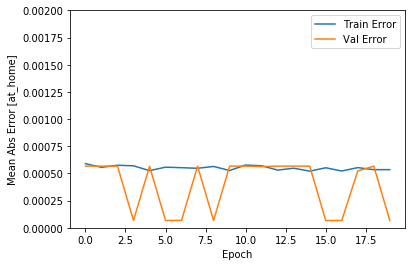

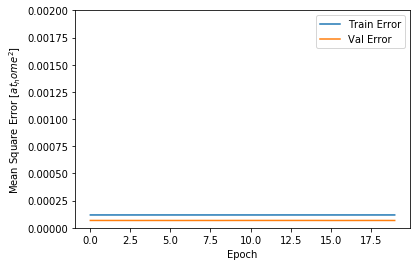

In [62]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [at_home]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.002])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$at_home^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.002])
  plt.legend()
  plt.show()


plot_history(history)
